In [58]:
import os
import pandas as pd
import numpy as np
import nltk
import random
from nltk import FreqDist
from nltk.classify import NaiveBayesClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from nltk.classify.util import accuracy as nltk_accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
import sklearn
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

In [59]:
def label_files_by_directory(root_dir):
    labeled_data = []  # List to store labeled data
    
    for dir_path, _, files in os.walk(root_dir):
        directory_name = os.path.basename(dir_path)
        
        for file_name in files:
            if file_name.endswith(".txt"):  # Only consider text files
                file_path = os.path.join(dir_path, file_name)
                with open(file_path, 'r', encoding='utf-8') as file:
                    file_content = file.read()
                
                labeled_data.append((file_content, directory_name))
                
    return labeled_data

In [60]:
# Provide the root directory where your text files are located
root_directory = "/Users/jacquelineduong/Downloads/reviews"
labeled_data = label_files_by_directory(root_directory)

# Create a DataFrame
data = pd.DataFrame(labeled_data, columns=['Text', 'Label'])
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

# Print the number of observations in each review score
print(data.groupby('Label').count())

       Text
Label      
1      1522
2      1088
3       944
4      1775
5      1162


In [61]:
# Initialize NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacquelineduong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacquelineduong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacquelineduong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [63]:
# Preprocess and replace paragraphs in the dataset
for idx, row in data.iterrows():
    paragraph = row['Text']

    # Convert to lowercase
    paragraph = paragraph.lower()

    # Remove punctuation
    paragraph = paragraph.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    words = word_tokenize(paragraph)

    # Remove stop words and lemmatize
    filtered_words = []
    for word in words:
        if word not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word)
            filtered_words.append(lemmatized_word)

    preprocessed_paragraph = ' '.join(filtered_words)

    # Update the dataset with the preprocessed paragraph
    data.at[idx, 'Text'] = preprocessed_paragraph

In [64]:
data_prepped = data.copy()

In [65]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2048, ngram_range=(1, 3))

# Fit and transform the paragraphs to obtain TF-IDF vectors
vectors = vectorizer.fit_transform(data_prepped.Text)

# Convert the TF-IDF vectors to a dense array for better readability
vectors_array = vectors.toarray()
vectors_df = pd.DataFrame(vectors_array, columns=vectorizer.get_feature_names_out())

In [66]:
X = vectors_df.copy()
y = data_prepped['Label'].copy()

In [67]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.1, random_state=42)

In [68]:
smote = SMOTE(sampling_strategy='auto')  # Adjust the sampling strategy

In [69]:
train_data, train_labels = smote.fit_resample(train_data, train_labels)

### Logistic Regression Model

In [70]:
# Initialize Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(train_data, train_labels)

# Make predictions on the test set
lr_predictions = logreg_model.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_labels, lr_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.45384615384615384


/Users/jacquelineduong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Model

In [79]:
# Initialize Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=69, random_state=42)

# Train the Random Forest model
random_forest_model.fit(train_data, train_labels)

# Make predictions on the test set using Random Forest
rf_predictions = random_forest_model.predict(test_data)

# Calculate accuracy for Random Forest
rf_accuracy = accuracy_score(test_labels, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.45076923076923076


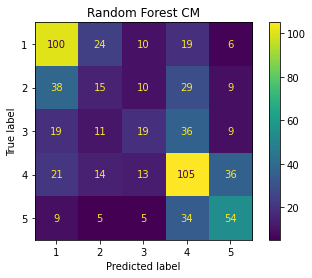

In [80]:
cm = sklearn.metrics.confusion_matrix(test_labels, rf_predictions, labels = random_forest_model.classes_)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = random_forest_model.classes_)
cm_display.plot()
plt.title("Random Forest CM")
plt.show()

In [81]:
feature_importance = pd.DataFrame({'Feature': test_data.columns, 'Importance': random_forest_model.feature_importances_})

# Sort feature importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.head(25))

         Feature  Importance
769        great    0.011181
756         good    0.008211
1988        work    0.007756
1035        love    0.007369
536         easy    0.006934
1202         one    0.006827
272       camera    0.006168
1898         use    0.005574
1492      return    0.005100
1117       month    0.004904
1372     product    0.004797
732          get    0.004718
991         like    0.004684
1354       price    0.004524
1277       phone    0.004307
1400     quality    0.004303
1955        well    0.004255
569         even    0.004197
1813        time    0.004067
2009       would    0.004014
1845       tried    0.003813
229       bought    0.003773
1938       waste    0.003751
1267     perfect    0.003747
1991  work great    0.003596


### Gradient Boosting Model

In [72]:
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

#train the Gradient Boosting model
gbm_model.fit(train_data, train_labels)

#make predictions
gbm_predictions = gbm_model.predict(test_data)

#calculate accuracy
gbm_accuracy = accuracy_score(test_labels, gbm_predictions)
print("Gradient Boosting Accuracy:", gbm_accuracy)

Gradient Boosting Accuracy: 0.44461538461538463


### Multinomial Naive Bayes Model

In [75]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

#train the Multinomial Naive Bayes model
nb_model.fit(train_data, train_labels)

#make predictions
nb_predictions = nb_model.predict(test_data)

#calculate accuracy
nb_accuracy = accuracy_score(test_labels, nb_predictions)
print("Multinomial Naive Bayes Accuracy:", nb_accuracy)

Multinomial Naive Bayes Accuracy: 0.46923076923076923


### Multilayer Perceptron

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

#split datasets
X = data['Text']  # Features
y = data['Label']  # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#convert text to numerical features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, 
                                   stop_words='english',
                                   max_df=0.7,
                                   lowercase=True)

#fit and transform the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#create the MLPClassifier with chosen hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

#train the MLP model on the training data
mlp_classifier.fit(X_train_tfidf, y_train)

#use the trained model to make predictions
y_pred = mlp_classifier.predict(X_test_tfidf)

#evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.43


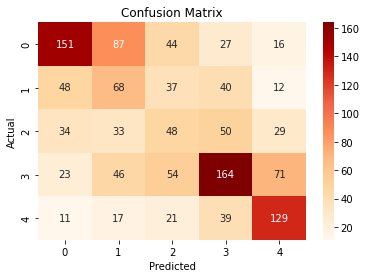

In [77]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [78]:
classification_report = metrics.classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report)

Classification Report:
               precision    recall  f1-score   support

           1       0.57      0.46      0.51       325
           2       0.27      0.33      0.30       205
           3       0.24      0.25      0.24       194
           4       0.51      0.46      0.48       358
           5       0.50      0.59      0.54       217

    accuracy                           0.43      1299
   macro avg       0.42      0.42      0.42      1299
weighted avg       0.44      0.43      0.43      1299

